In [1]:
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import MultiprocessingEvaluator, ema_logging
import pickle

In [2]:
model, _ = get_model_for_problem_formulation(2)

In [3]:
from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 500 #In assignment 5 is at first 1000 used and later on for the dimensional stacking 10000. 
n_policies = 50 #Not sure if we have to go for 8 again here like in the earlier exploratory modeling

use_pickle1 = False 
if use_pickle1:
    with open('data/PRIM_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies, uncertainty_sampling=Samplers.LHS)
    
    with open('data/PRIM_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 500 scenarios * 50 policies * 1 model(s) = 25000 experiments
100%|████████████████████████████████████| 25000/25000 [35:13<00:00, 11.83it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
experiments, outcomes = results

In [5]:
cleaned_experiments = experiments.drop(['policy','scenario','model'],axis=1)
# we drop 3 columns here

In [6]:
import numpy as np

data = outcomes['Expected Number of Deaths']
y = data < np.percentile(data,50) #Only pick the 50th percentile

In [7]:
#threshold (float) – the density threshold that a box has to meet
#Not sure which tresholds we need to use?
prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8, peel_alpha=0.05) 
box1 = prim_alg.find_box()

[MainProcess/INFO] 25000 points remaining, containing 12500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.06608, coverage: 0.13216, density: 1.0 restricted_dimensions: 13


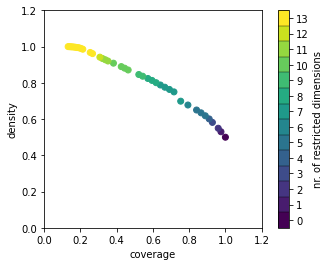

In [8]:
box1.show_tradeoff()
plt.show()

coverage     0.13216
density      1.00000
id          38.00000
mass         0.06608
mean         1.00000
res_dim     13.00000
Name: 38, dtype: float64

                      box 38             \
                         min        max   
A.5_DikeIncrease 1  0.000000   9.500000   
A.4_DikeIncrease 1  0.000000   9.500000   
A.3_pfail           0.460530   0.998670   
A.2_DikeIncrease 0  2.500000  10.000000   
A.2_pfail           0.279802   0.998589   
A.5_pfail           0.223683   0.998179   
A.5_DikeIncrease 0  0.500000  10.000000   
EWS_DaysToThreat    0.500000   4.000000   
A.4_pfail           0.106431   0.998125   
A.4_DikeIncrease 0  0.500000   9.500000   
A.1_DikeIncrease 2  0.500000  10.000000   
A.3_DikeIncrease 0  0.500000  10.000000   
A.1_pfail           0.065992   0.932555   

                                                                    
                                                         qp values  
A.5_DikeIncrease 1                  [-1.0, 2.2184534235548064e-3

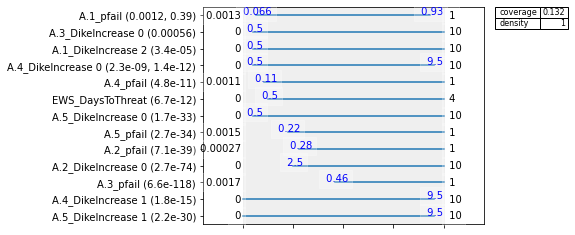

In [9]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [10]:
from ema_workbench.analysis import dimensional_stacking

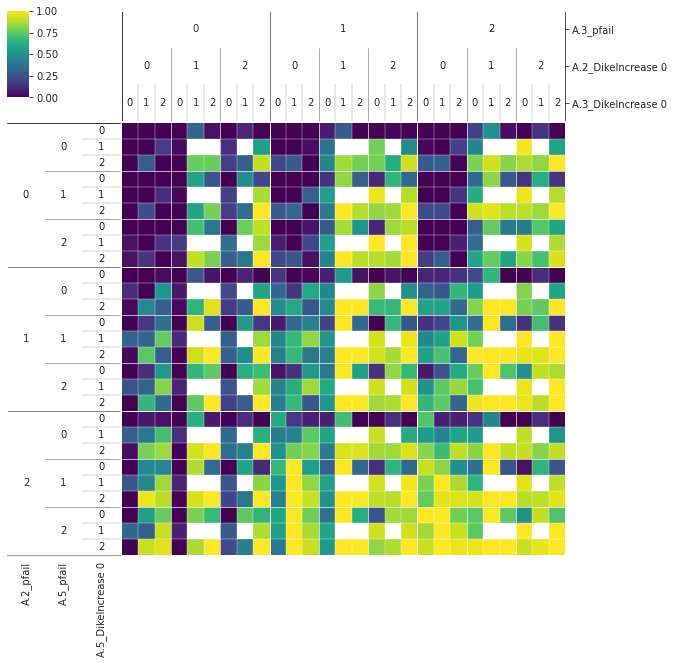

In [11]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()